[INFO] Using format CF32.


Failed to read samples from SDR


[WARNING] Read Timeout occured after 100000 ms


Peak Frequency (MHz) Refined Bandwidth (MHz)   Power (dB)     
92.007               0.000 kHz                 -33.90         
98.091               375.977 kHz               -10.84         
99.029               156.250 kHz               -31.65         
99.998               117.188 kHz               -23.95         
100.962              134.277 kHz               -29.37         
102.105              112.305 kHz               -19.34         
102.903              183.105 kHz               -11.07         
103.704              141.602 kHz               -22.79         
104.771              19.531 kHz                -19.76         
111.998              0.000 kHz                 -30.74         


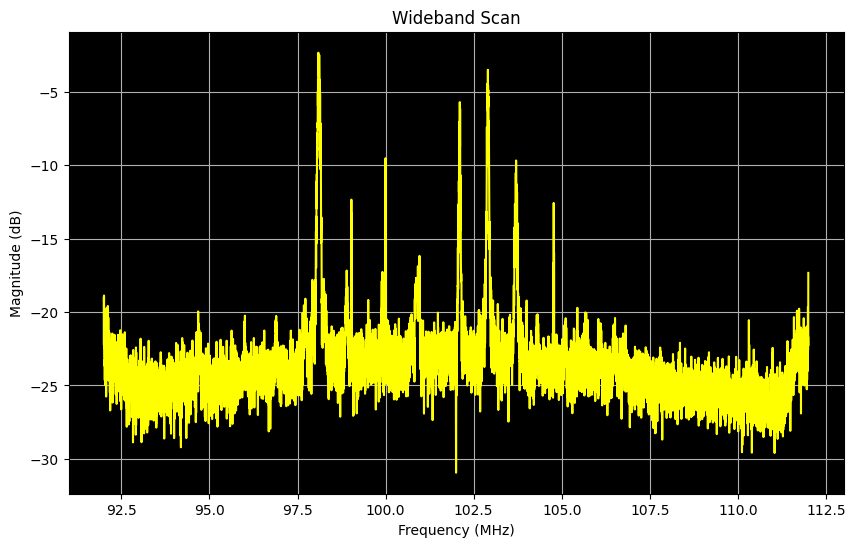

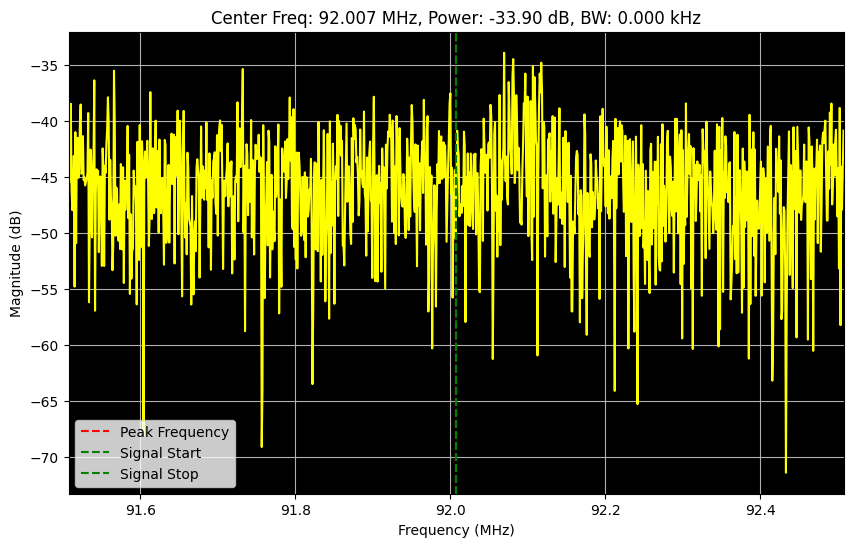

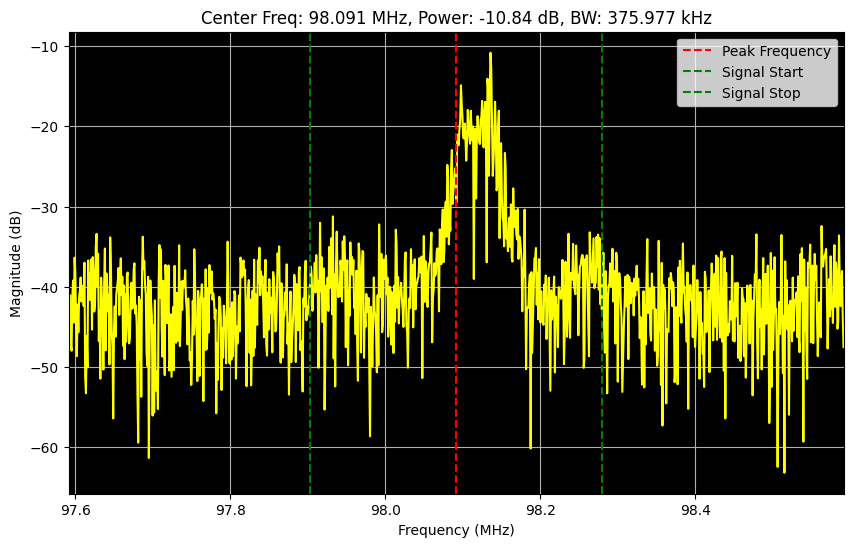

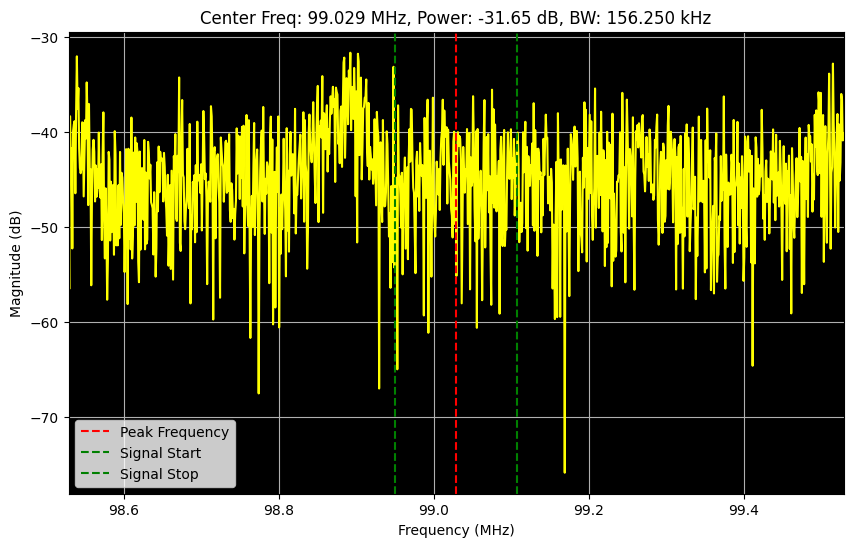

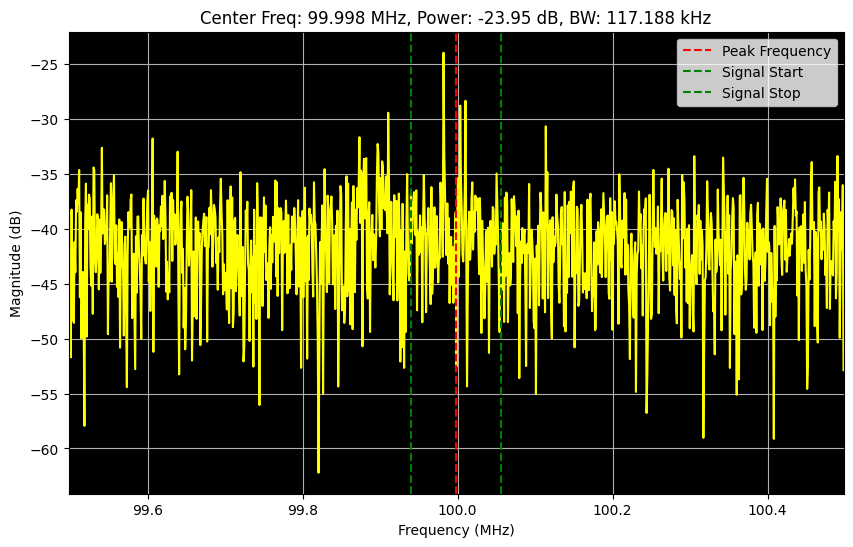

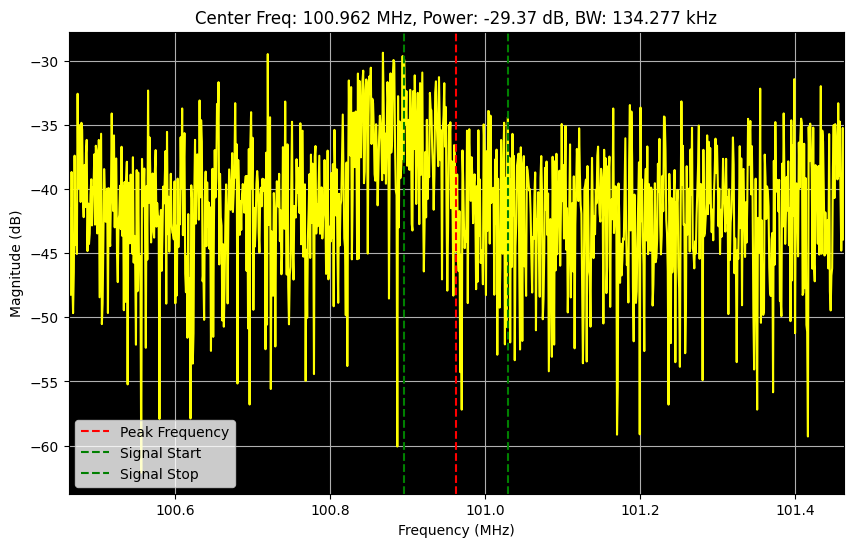

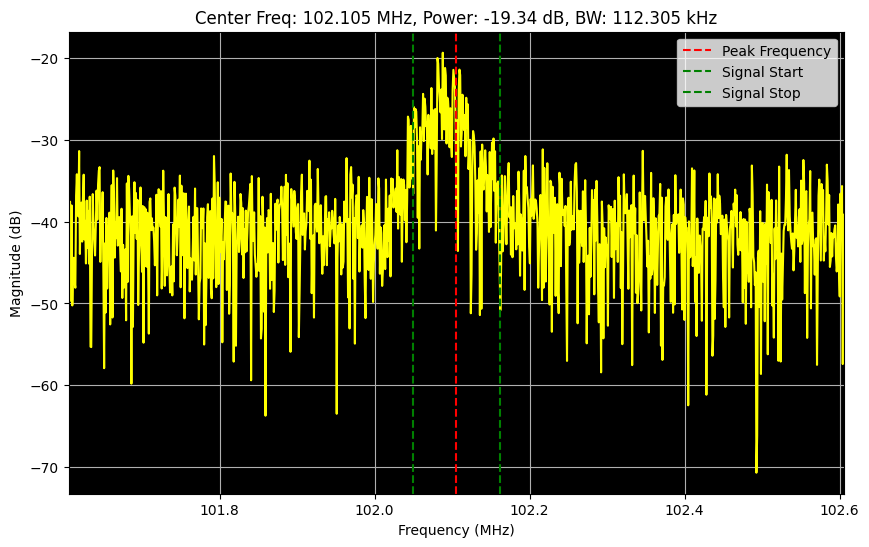

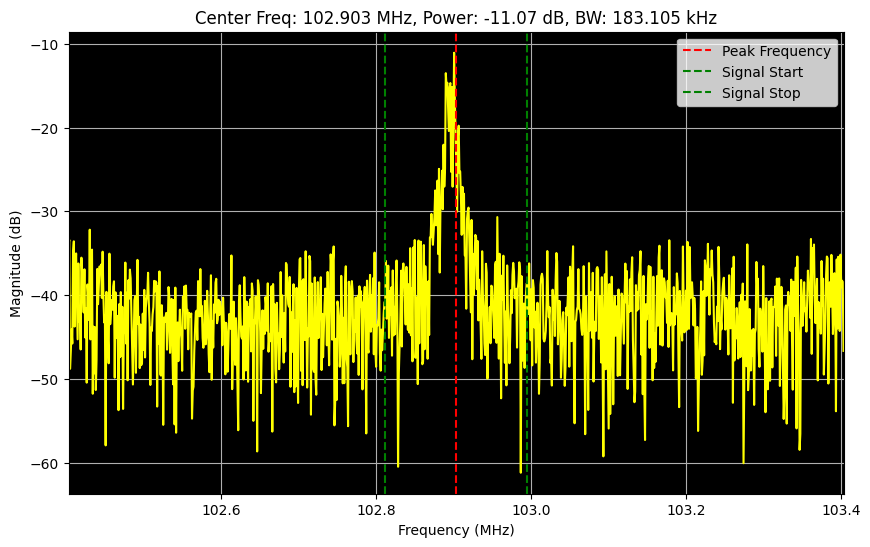

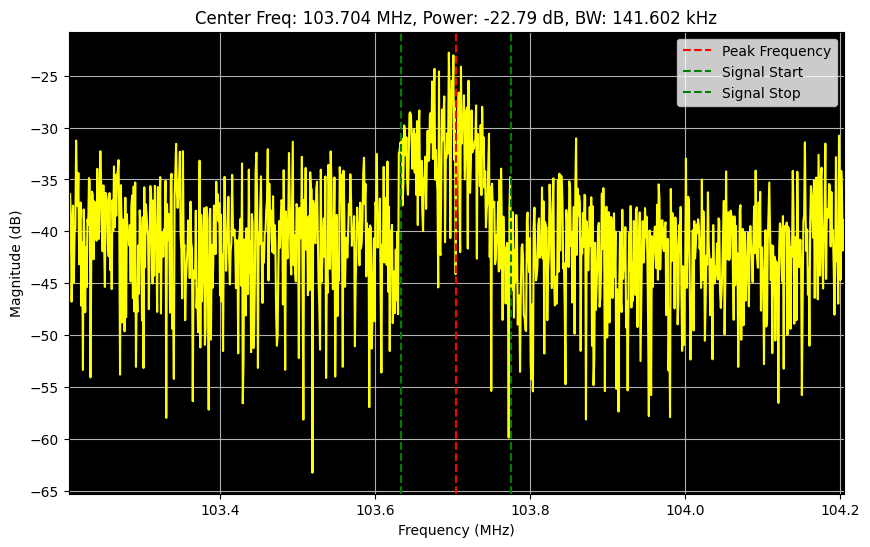

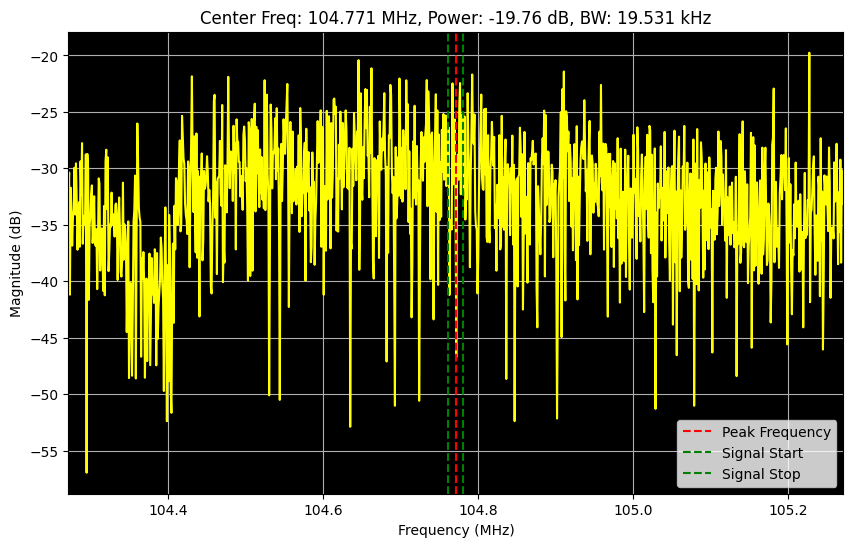

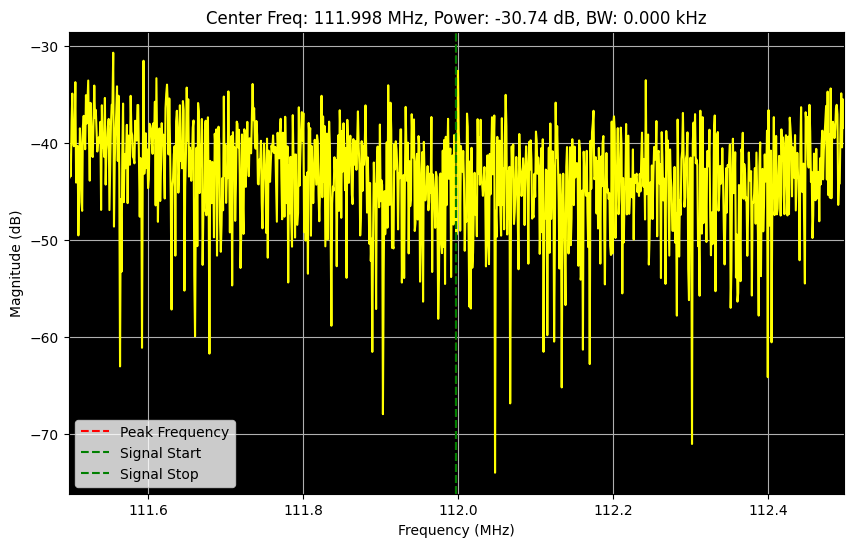

: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sdrfly.sdr.sdr_generic import SDRGeneric
from sdr_plot_backend.signal_utils import detect_signal_peaks
import time
import pickle

def perform_and_refine_scan(sdr, center_freq, sample_rate, fft_size, num_captures, output_filename="scan_data.pkl"):
    """
    Perform a wideband scan and refine the detected peaks.

    Args:
        sdr (SDRGeneric): The SDR object to perform the scan with.
        center_freq (float): Center frequency for the wideband scan in Hz.
        sample_rate (float): Sample rate for the wideband scan in Hz.
        fft_size (int): The size of the FFT.
        num_captures (int): Number of captures to average.
        output_filename (str): The filename to save the scan data.

    Returns:
        list: List of detected peaks, each as a dictionary containing peak frequency, bandwidth, and power.
    """

    # Start the wideband scan
    sdr.set_frequency(center_freq)
    sdr.set_sample_rate(sample_rate)
    sdr.set_bandwidth(sample_rate)
    time.sleep(0.1)
    
    fft_magnitude_sum = np.zeros(fft_size)
    for _ in range(num_captures):
        iq_data = sdr.get_latest_samples()
        fft_result = np.fft.fftshift(np.fft.fft(iq_data, fft_size))
        fft_magnitude = np.abs(fft_result)
        fft_magnitude_sum += fft_magnitude

    fft_magnitude_avg = fft_magnitude_sum / num_captures
    fft_magnitude_db = 20 * np.log10(fft_magnitude_avg)

    # Detect peaks and bandwidths
    signal_peaks, signal_bandwidths = detect_signal_peaks(
        fft_magnitude_db, center_freq, sample_rate, fft_size, min_peak_distance=10 * 8, threshold_offset=5
    )

    # Save the wideband FFT data to a pickle file
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'center_freq': center_freq,
            'sample_rate': sample_rate,
            'fft_magnitude_db': fft_magnitude_db,
            'frequencies': np.linspace(center_freq - sample_rate / 2, center_freq + sample_rate / 2, fft_size),
            'signal_peaks': signal_peaks,
            'signal_bandwidths': signal_bandwidths
        }, f)

    detected_peaks = []

    # Refine each detected peak
    for peak, original_bandwidth in zip(signal_peaks, signal_bandwidths):
        sdr.set_frequency(peak * 1e6)
        sdr.set_sample_rate(1e6)
        sdr.set_bandwidth(1e6)
        time.sleep(0.1)
        
        fft_captures = []
        for _ in range(num_captures):
            iq_data = sdr.get_latest_samples()
            fft_result = np.fft.fftshift(np.fft.fft(iq_data, 1024))
            fft_magnitude = np.abs(fft_result)
            fft_captures.append(fft_magnitude)

        refined_fft_magnitude_avg = np.mean(fft_captures, axis=0)
        refined_fft_magnitude_db = 20 * np.log10(refined_fft_magnitude_avg)

        noise_floor = np.median(refined_fft_magnitude_db)
        adaptive_threshold = noise_floor + 5
        above_threshold = np.where(refined_fft_magnitude_db > adaptive_threshold)[0]
        if len(above_threshold) > 0:
            left_idx = above_threshold[0]
            right_idx = above_threshold[-1]
            refined_bandwidth_mhz = (right_idx - left_idx) * (1e6 / 1024)
        else:
            refined_bandwidth_mhz = 0.0

        # Ensure the refined bandwidth is not an order of magnitude larger than the original
        if refined_bandwidth_mhz > 10 * original_bandwidth:
            refined_bandwidth_mhz = original_bandwidth

        detected_peaks.append({
            'peak_freq': peak,
            'refined_bandwidth_mhz': refined_bandwidth_mhz,
            'power': np.max(refined_fft_magnitude_db)
        })

        # Save the refined FFT data to the same pickle file
        with open(output_filename, 'ab') as f:
            pickle.dump({
                'peak_freq': peak,
                'refined_fft_magnitude_db': refined_fft_magnitude_db,
                'refined_frequencies': np.linspace(peak * 1e6 - 0.5 * 1e6, peak * 1e6 + 0.5 * 1e6, len(refined_fft_magnitude_db)),
                'refined_bandwidth_mhz': refined_bandwidth_mhz
            }, f)

    return detected_peaks

# Initialize the SDR
sdr = SDRGeneric(
    sdr_type="sidekiq",
    center_freq=102e6,
    sample_rate=20e6,
    bandwidth=20e6,
    gain=60,
    size=1024 * 8
)
sdr.start()

# Perform the scan and refine process
detected_peaks = perform_and_refine_scan(
    sdr,
    center_freq=102e6,
    sample_rate=20e6,
    fft_size=1024 * 8,
    num_captures=20,
    output_filename="scan_data.pkl"
)

sdr.stop()

# Print detected peaks
print(f"{'Peak Frequency (MHz)':<20} {'Refined Bandwidth (MHz)':<25} {'Power (dB)':<15}")
print("=" * 60)
for peak_info in detected_peaks:
    bw = peak_info['refined_bandwidth_mhz']
    bw_str = f"{bw:.3f} MHz" if bw >= 1 else f"{bw * 1e3:.3f} kHz"
    print(f"{peak_info['peak_freq']:<20.3f} {bw_str:<25} {peak_info['power']:<15.2f}")

# Load and visualize the results
with open("scan_data.pkl", 'rb') as f:
    data_list = []
    try:
        while True:
            data = pickle.load(f)
            data_list.append(data)
    except EOFError:
        pass

# Plot the wideband scan
wideband_data = data_list[0]
plt.figure(figsize=(10, 6))
plt.plot(wideband_data['frequencies'] / 1e6, wideband_data['fft_magnitude_db'], color='yellow')
plt.title("Wideband Scan")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.gca().set_facecolor('black')
plt.show()

# Plot the refined scans
for refined_data in data_list[1:]:
    plt.figure(figsize=(10, 6))
    plt.plot(refined_data['refined_frequencies'] / 1e6, refined_data['refined_fft_magnitude_db'], color='yellow')
    plt.axvline(refined_data['peak_freq'], color='red', linestyle='--', label="Peak Frequency")
    plt.axvline((refined_data['peak_freq'] - refined_data['refined_bandwidth_mhz'] / 2), color='green', linestyle='--', label="Signal Start")
    plt.axvline((refined_data['peak_freq'] + refined_data['refined_bandwidth_mhz'] / 2), color='green', linestyle='--', label="Signal Stop")
    bw_str = f"{refined_data['refined_bandwidth_mhz']:.3f} MHz" if refined_data['refined_bandwidth_mhz'] >= 1 else f"{refined_data['refined_bandwidth_mhz'] * 1e3:.3f} kHz"
    plt.title(f"Center Freq: {refined_data['peak_freq']:.3f} MHz, Power: {np.max(refined_data['refined_fft_magnitude_db']):.2f} dB, BW: {bw_str}")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.legend()
    plt.gca().set_facecolor('black')
    plt.xlim(refined_data['peak_freq'] - 0.5, refined_data['peak_freq'] + 0.5)  # Center the plot around the refined peak with 1 MHz bandwidth
    plt.show()
